In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
from utlis import tools
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset,DataLoader
from torch import nn, optim

import os

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')

import time

In [2]:
from multiprocessing import Pool

## 1. Load Preprocessed Data

In [3]:
# path to the data
dataPath = './dataset/data_combined.csv'

# size of sliding window
lagWindowSize=30

In [4]:
def load_n_preprocess_data(dataPath, lagWindowSize=10):
    ## 1. Load labelled data
    print("Load Labelled Data")
    #X, y = tools.load_labelled_data(dataPath, isLeft=True)
    X, y = tools.load_labelled_data_combine(dataPath)
    
    ## 2. Generate Time-lagged data
    print("Generate Time-lagged Data")
    X_lag, y_lag = tools.generate_time_lags(X, y, lagWindowSize)
    ## 3. Convert 2D dataframe to 3D numpy array: (Batch, TimeLag, Features)
    print("Convert 2D dataframe to 3D numpy array")
    X_3D = tools.convert_df_2_np_3D(X_lag, lagWindowSize)
    return X_3D, y_lag

In [5]:
# Save/Load data
if(os.path.exists('./dataset/X_{}.npy'.format(lagWindowSize))):
    X_3D = np.load('./dataset/X_{}.npy'.format(lagWindowSize))
    y_lag = np.load('./dataset/y_{}.npy'.format(lagWindowSize))
else:
    start = time.time()
    print("Load and Preprocessing")
    X_3D, y_lag = load_n_preprocess_data(dataPath,
                                         lagWindowSize=lagWindowSize)
    y_lag = y_lag.to_numpy()
    np.save('./dataset/X_{}.npy'.format(lagWindowSize), X_3D)
    np.save('./dataset/y_{}.npy'.format(lagWindowSize), y_lag)

    end = time.time()
    elapsed_time = end - start
    print('Execution time:', elapsed_time, 'seconds')

In [6]:
output_dimension = 5

In [7]:
X_3D.shape

(46963, 30, 78)

In [8]:
np.max(y_lag)

4.0

## 2. Split data into training & test set

In [9]:
def split_train_n_test(X, y, test_size=0.4, val_size=0.1):
    # Convert dataframe to numpy
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size,
                                                        shuffle=False,
                                                        random_state=2022)
    val_size = val_size/(1-test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=val_size, 
                                                      shuffle=False,
                                                      random_state=2022)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = split_train_n_test(
                                                      X_3D, y_lag, 
                                                      test_size=0.21,
                                                      val_size=0.1
                                                     )

In [11]:
X_train.shape

(32403, 30, 78)

In [12]:
y_train.shape

(32403, 1)

In [13]:
X_val.shape

(4697, 30, 78)

In [14]:
X_test.shape

(9863, 30, 78)

## 3. Convert datasets into pyTorch format 

In [15]:
from utlis import augmentation as aug
import random

In [16]:
def augment_feature_with_prob(X, prob):
    if(random.random()<prob):
        X = X.reshape((1, X.shape[0], X.shape[1]))
        #X = aug.window_warp(X, 0.05)
        X = aug.jitter(X, 0.05)
        X = np.squeeze(X)
    return X

In [17]:
class torchDataset(Dataset):
    def __init__(self, X, y, augment_flag=False, num_processes=16):
        self.X = X
        self.y = y
        self.augment_flag = augment_flag
        self.num_processes = num_processes

    @staticmethod
    def augment(X, num_processes):
        #X_aug = ts_augmenter.augment(X)
        X_aug = augment_feature_with_prob(X, 0.05)
        #X_aug = np.stack([ts_augmenter.augment(x) for x in X])
#         X_2_aug = [x for x in X]
#         with Pool(num_processes) as pool:
#             X_aug = np.stack(pool.map(augment_feature, X_2_aug))
        return X_aug
    
    @staticmethod
    def to_torch_tensor(X, y):
        X = torch.tensor(X).float()
        y = torch.tensor(y).float()
        return X,y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        Xi, yi = self.X[i], self.y[i]
        if(self.augment_flag):
            Xi = torchDataset.augment(Xi, self.num_processes)
        Xi,yi = torchDataset.to_torch_tensor(Xi,yi)
        return Xi,yi

In [18]:
trainSet = torchDataset(X_train, y_train, True, 1)
valSet = torchDataset(X_val, y_val, True)
testSet = torchDataset(X_test, y_test)

In [19]:
np.max(y_train)

4.0

In [20]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

batch_size = 64

train_loader = DataLoader(trainSet, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valSet, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testSet, batch_size=1, shuffle=False)

In [21]:
%%time
X, Y = next(iter(train_loader))
print("Batch Features shape:", X.shape)
print("Batch Target shape:", Y.shape)

Batch Features shape: torch.Size([64, 30, 78])
Batch Target shape: torch.Size([64, 1])
CPU times: user 4.26 ms, sys: 273 µs, total: 4.53 ms
Wall time: 12.9 ms


In [22]:
X.shape

torch.Size([64, 30, 78])

## 4. Import models

In [23]:
# check GPU availability               
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Run on {}...".format(device))

Run on cuda...


In [24]:
from models import GRU, CNN2DGRU

Imported Time-Seise Neural Network Models


In [25]:
'''
model = GRU.GRUModel(input_dim=X.shape[-1], 
                    hidden_dim=10, 
                    layer_dim=3, 
                    output_dim=2, 
                    dropout_prob=0.5)
'''

'\nmodel = GRU.GRUModel(input_dim=X.shape[-1], \n                    hidden_dim=10, \n                    layer_dim=3, \n                    output_dim=2, \n                    dropout_prob=0.5)\n'

In [26]:
X.shape[-1]

78

In [27]:
model = CNN2DGRU.CNN2DGRUModel(input_dim=X.shape[-1], 
                    hidden_dim=20, 
                    layer_dim=3, 
                    output_dim=output_dimension, 
                    dropout_prob=0.5)

## 5. Train, Update, and Test

In [28]:
def train(dataloader, model, criterion, optimizer, scheduler, device):
    model.train()
    epoch_losses = []
    #epoch_mses = []
    epoch_accs = []
    
    for X, y in dataloader:
        X, y = X.to(device), y.type(torch.LongTensor).to(device)
        #X, y = X.to(device), y.type(torch.float32).to(device)
        #X[:, :, 93:168] = 0
        y_hat = model(X)
        loss = criterion(y_hat, y.squeeze(dim=1))
        #loss = criterion(y_hat.argmax(dim=-1), y.squeeze(dim=1))
        accuracy = get_accuracy(y_hat, y.squeeze(dim=1))
        #real_mse = real_mean_square_error(y_hat, y)
        optimizer.zero_grad()
        loss.backward()

        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        
        optimizer.step()
        epoch_losses.append(loss.item())
        #epoch_mses.append(real_mse)
        epoch_accs.append(accuracy.item())
        scheduler.step()
    return epoch_losses, epoch_accs#epoch_mses

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    #epoch_mses = []
    epoch_accs = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.type(torch.LongTensor).to(device)
            #X, y = X.to(device), y.type(torch.float32).to(device)
            #X[:, :, 93:168] = 0
            y_hat = model(X)
            loss = criterion(y_hat, y.squeeze(dim=1))
            #loss = criterion(y_hat.argmax(dim=-1), y.squeeze(dim=1))
            accuracy = get_accuracy(y_hat, y.squeeze(dim=1))
            #real_mse = real_mean_square_error(y_hat, y)
            epoch_losses.append(loss.item())
            #epoch_mses.append(real_mse)
            epoch_accs.append(accuracy.item())
    return epoch_losses, epoch_accs#epoch_mses

def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [29]:
class ConstantWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(
        self,
        optimizer,
        num_warmup_steps: int,
    ):
        self.num_warmup_steps = num_warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        if self._step_count <= self.num_warmup_steps:
            # warmup
            scale = 1.0 - (self.num_warmup_steps - self._step_count) / self.num_warmup_steps
            lr = [base_lr * scale for base_lr in self.base_lrs]
            self.last_lr = lr
        else:
            # every 10 steps, exponentially decay by multipling 0.95
            if self._step_count % 2000 == 0:
                self.base_lrs = [base_lr * 0.9 for base_lr in self.base_lrs]
                print("Learning Rate Decay - lr: {}".format(self.base_lrs[0]))
            lr = self.base_lrs
        return lr

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [31]:
def loss_weight_balance(DataLoader):
    label_range = output_dimension
    Y = torch.Tensor([])
    for _, y in DataLoader:
        Y = torch.cat((Y, y.squeeze(dim=1)))
    Y = Y.numpy()
    totalNum = len(Y)
    ratios = np.array([])
    for i in range(label_range):
        ratio = np.sum((Y == float(i))*1)/totalNum        
        ratios = np.append(ratios, ratio)
    print("Label Distribution: {}".format(ratios))
    ratios = ratios
    weights = np.array([])
    for i in range(label_range):       
        weights = np.append(weights, 1.0/ratios[i])
    weights = weights/np.sum(weights)
    print("Label Weights: {}".format(weights))
    return weights

In [32]:
trainSet.__getitem__(i=0)[0].shape

torch.Size([30, 78])

In [33]:
def train_and_test_model_with_hparams(hparams, model_type="lstm", **kwargs):

    torch.manual_seed(hparams.SEED)
    random.seed(hparams.SEED)
    np.random.seed(hparams.SEED)
    
    train_loader = DataLoader(trainSet, batch_size=hparams.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(valSet, batch_size=hparams.BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(testSet, batch_size=hparams.BATCH_SIZE, shuffle=True)
    
    X, _ = trainSet.__getitem__(i=0)
    feature_size = X.shape[1]
    
    # Model
    if model_type=="gru":
        model = GRU.GRUModel(
            input_dim = feature_size, 
            hidden_dim = hparams.HIDDEN_DIM, 
            output_dim = hparams.OUTPUT_DIM,
            layer_dim = hparams.N_LAYERS,
            dropout_prob = hparams.DROPOUT_RATE, 
            **kwargs)
    elif model_type=="cnn2dgru":
        model = CNN2DGRU.CNN2DGRUModel(
            input_dim = feature_size, 
            hidden_dim = hparams.HIDDEN_DIM, 
            output_dim = hparams.OUTPUT_DIM,
            layer_dim = hparams.N_LAYERS,
            dropout_prob = hparams.DROPOUT_RATE, 
            **kwargs)
        
    num_params = count_parameters(model)
    print(f'The model has {num_params:,} trainable parameters')

    model = model.to(device)

    if hparams.OPTIM == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, momentum=.9)        
    elif hparams.OPTIM == "adagrad":
        optimizer = optim.Adagrad(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "adam":
        optimizer = optim.Adam(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6)
    elif hparams.OPTIM == "rmsprop":
        optimizer = optim.RMSprop(
            model.parameters(), lr=hparams.LR, weight_decay=hparams.WD, eps=1e-6, momentum=.9)
    else:
        raise NotImplementedError("Optimizer not implemented!")

    
    ## ! Balance the loss for imbalanced dataset
    weights = loss_weight_balance(train_loader)

    weights[0], weights[1], weights[2], weights[3] = weights[0]*2, weights[1]*2, weights[2]*2, weights[3]*2
    weights = torch.Tensor(weights)
    criterion = nn.CrossEntropyLoss(weight=weights)
    #criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    # Start training
    best_valid_loss = float('inf')
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    # Warmup Scheduler.
    WARMUP_STEPS = 100
    lr_scheduler = ConstantWithWarmup(optimizer, WARMUP_STEPS)

    train_loss_records = []
    valid_loss_records = []
    
    for epoch in range(hparams.N_EPOCHS):
        
        # Your code: implement the training process and save the best model.
        train_losses, train_acc = train(dataloader=train_loader, 
                                      model=model, 
                                      criterion=criterion, 
                                      optimizer=optimizer, 
                                      scheduler=lr_scheduler, 
                                      device=device)
        valid_losses, valid_acc = evaluate(dataloader=val_loader,
                                         model=model,
                                         criterion=criterion,
                                         device=device)
        
        #print(train_real_mses.shape)
        epoch_train_loss = np.mean(train_losses)
        epoch_train_acc = np.mean(train_acc)
        epoch_valid_loss = np.mean(valid_losses)
        epoch_valid_acc = np.mean(valid_acc)
        train_loss_records += train_losses
        valid_loss_records += valid_losses
        

        # Save the model that achieves the smallest validation loss.
        if epoch >=3:
            if epoch_valid_loss < best_valid_loss:
                # Your code: save the best model somewhere (no need to submit it to Sakai)
                best_valid_loss = epoch_valid_loss
                if not os.path.exists(hparams.CHECKPOINT_FOLDER):
                    os.makedirs(hparams.CHECKPOINT_FOLDER)
                print("Saving ...")
                state = {'state_dict': model.state_dict(),
                         'epoch': epoch}
                torch.save(state, os.path.join(hparams.CHECKPOINT_FOLDER, model_type+'.pth'))
        if epoch%5 == 0:
            print(f'epoch: {epoch+1}')
            print(f'train_loss: {epoch_train_loss:.5f}, train_acc: {epoch_train_acc:.5f}')
            print(f'valid_loss: {epoch_valid_loss:.5f}, valid_acc: {epoch_valid_acc:.5f}')


    # Your Code: Load the best model's weights.
    state_dict = torch.load('./saved_model/'+model_type+'.pth')['state_dict']
    model.load_state_dict(state_dict)
    model.to(device)
    
    # Your Code: evaluate test loss on testing dataset (NOT Validation)
    test_losses, test_acc = evaluate(dataloader=test_loader, 
                                   model=model,
                                   criterion=criterion,
                                   device=device)

    epoch_test_loss = np.mean(test_losses)
    epoch_test_acc = np.mean(test_acc)
    print(f'test_loss: {epoch_test_loss:.5f}, test_acc: {epoch_test_acc:.5f}')
    
    # Free memory for later usage.
    #del model
    #torch.cuda.empty_cache()
    return {
        'model': model,
        'num_params': num_params,
        "test_loss": epoch_test_loss,
        "test_acc": epoch_test_acc,
        
        'train_loss_records': train_loss_records,
        'valid_loss_records': valid_loss_records
    }

In [34]:
class HyperParams:
    def __init__(self):
        self.BATCH_SIZE = 256
        self.HIDDEN_DIM = 128
        self.OUTPUT_DIM = output_dimension
        self.N_LAYERS = 3
        self.DROPOUT_RATE = 0.0
        self.LR = 5e-5
        self.N_EPOCHS = 50
        self.OPTIM = "rmsprop"
        self.SEED = 2
        self.WD = 0
        self.CHECKPOINT_FOLDER = 'saved_model'
        
hparams = HyperParams()
torch.manual_seed(hparams.SEED)
random.seed(hparams.SEED)
np.random.seed(hparams.SEED)

In [35]:
output_dimension

5

In [36]:
model_type = "cnn2dgru"
title = "gru_l3_h10_rmsprop"
gru_result = train_and_test_model_with_hparams(hparams, model_type)
model = gru_result['model']
#print(model)

The model has 333,885 trainable parameters
Label Distribution: [0.06940715 0.06659877 0.04740302 0.0446255  0.77196556]
Label Weights: [0.1941146  0.20230015 0.28422118 0.30191129 0.01745278]
epoch: 1
train_loss: 1.25492, train_acc: 0.28207
valid_loss: 1.68553, valid_acc: 0.29850
Saving ...
Saving ...
epoch: 6
train_loss: 1.03225, train_acc: 0.83274
valid_loss: 1.60828, valid_acc: 0.79235
Saving ...
epoch: 11
train_loss: 1.03321, train_acc: 0.84886
valid_loss: 1.59704, valid_acc: 0.85225
Learning Rate Decay - lr: 4.5e-05
Saving ...
epoch: 16
train_loss: 1.02802, train_acc: 0.85740
valid_loss: 1.45610, valid_acc: 0.82452
epoch: 21
train_loss: 0.98412, train_acc: 0.85784
valid_loss: 1.65954, valid_acc: 0.79253
epoch: 26
train_loss: 0.92587, train_acc: 0.91045
valid_loss: 1.63874, valid_acc: 0.80700
epoch: 31
train_loss: 0.92702, train_acc: 0.90618
valid_loss: 1.64241, valid_acc: 0.78572
Learning Rate Decay - lr: 4.05e-05
epoch: 36
train_loss: 0.92584, train_acc: 0.91631
valid_loss: 1.634

# Evaluation

In [37]:
def plot_train_valid_loss(result, title):
    train_loss = result['train_loss_records']
    valid_loss = result['valid_loss_records']
    valid_iter = [int((len(train_loss)/len(valid_loss))*x) \
                  for x in range(len(valid_loss))]
    plt.figure(figsize=(14, 6))
    plt.plot(train_loss, 'g', label='Training loss')
    plt.plot(valid_iter, valid_loss, 'b', label='Validation loss')
    plt.title(title)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()

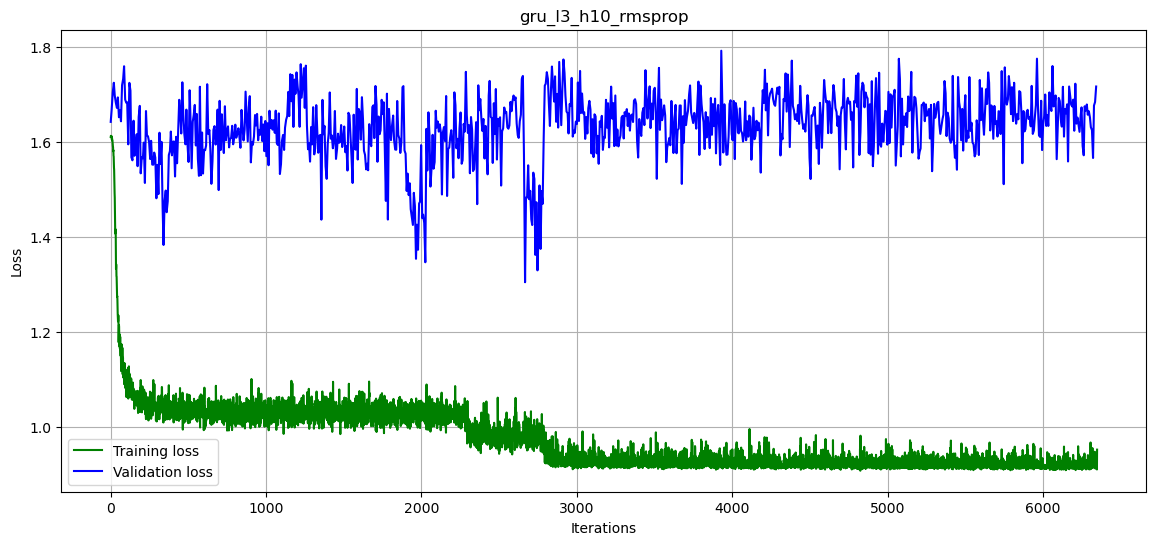

In [38]:
plot_train_valid_loss(gru_result, title)

In [39]:
def predict(data_loader, model):
    y_heads = torch.tensor([]).to(device)
    y_truth = torch.tensor([]) # Let it stays on CPU
    model.eval()
    #model.train()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y_star = model(X)
            y_heads = torch.cat((y_heads, y_star), 0)
            y_truth = torch.cat((y_truth, y), 0)
    del model
    torch.cuda.empty_cache()
    predicted_classes = y_heads.argmax(dim=-1)
    return predicted_classes.cpu().numpy(), y_truth.cpu().numpy()

def get_predict_accuracy(prediction, label):
    label = np.reshape(label, prediction.shape)
    correct_predictions = np.sum((prediction==label)*1)
    accuracy = correct_predictions / len(label)
    return accuracy

In [40]:
# train_loader = DataLoader(trainSet, batch_size=batch_size, shuffle=False)

# y_train_head, y_train  = predict(train_loader, model)

start = time.time()
#### Testset
y_test_head, y_test = predict(test_loader, model)
end = time.time()
elapsed_time = end - start
print('Test Set Execution time:', elapsed_time, 'seconds')

Test Set Execution time: 4.021122455596924 seconds


In [41]:
def moving_majority(array, window_size):
    """
    Apply moving majority operation to the array.
    
    Parameters:
        array (numpy.ndarray): Input array.
        window_size (int): Size of the moving window.
    
    Returns:
        numpy.ndarray: Array after applying moving majority operation.
    """
    pad_width = window_size // 2
    padded_array = np.pad(array, pad_width, mode='edge')
    output = np.zeros_like(array, dtype=int)
    unique_labels = np.unique(array)
    
    for i in range(len(array)):
        window = padded_array[i:i+window_size]
        counts = [np.sum(window == label) for label in unique_labels]
        majority_label = unique_labels[np.argmax(counts)]
        output[i] = majority_label
    
    return output

In [42]:
y_test_head = moving_majority(y_test_head, window_size=20)

In [43]:
def visual_output(y, y_head, title):
    fig = plt.figure(figsize=(14,3))
    plt.plot(y, color='g', label='truth')
    if y_head is not None:
        plt.plot(y_head, color='b', alpha=0.5, label='predict')
        accuracy = get_predict_accuracy(y_head, y)
        plt.title(title+"- acc: {:.5f}".format(accuracy))
    #plt.ylim(-0.01, (np.mean(y_head)+np.mean(y))*2)
    else:
        plt.title(title)
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.grid()
    plt.legend()
    plt.show()

In [44]:
np.min(y_test)

0.0

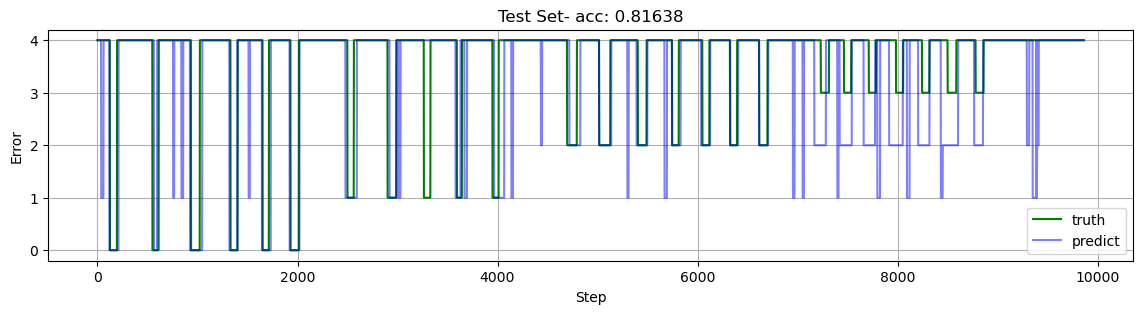

In [45]:
visual_output(y_test, y_test_head, "Test Set")

In [46]:
from sklearn import metrics
import seaborn as sns

In [47]:
print(metrics.classification_report(y_test, y_test_head, digits=4))

              precision    recall  f1-score   support

         0.0     0.7895    0.9205    0.8499       440
         1.0     0.3222    0.6474    0.4303       329
         2.0     0.3531    0.9524    0.5152       588
         3.0     0.0000    0.0000    0.0000       539
         4.0     0.9678    0.8628    0.9123      7967

    accuracy                         0.8164      9863
   macro avg     0.4865    0.6766    0.5415      9863
weighted avg     0.8487    0.8164    0.8199      9863



In [48]:
cm = metrics.confusion_matrix(y_test, y_test_head, normalize='true')
cm

array([[0.92045455, 0.        , 0.        , 0.        , 0.07954545],
       [0.        , 0.64741641, 0.        , 0.        , 0.35258359],
       [0.        , 0.        , 0.95238095, 0.        , 0.04761905],
       [0.        , 0.        , 0.90723562, 0.        , 0.09276438],
       [0.01355592, 0.05623196, 0.06740304, 0.        , 0.86280909]])

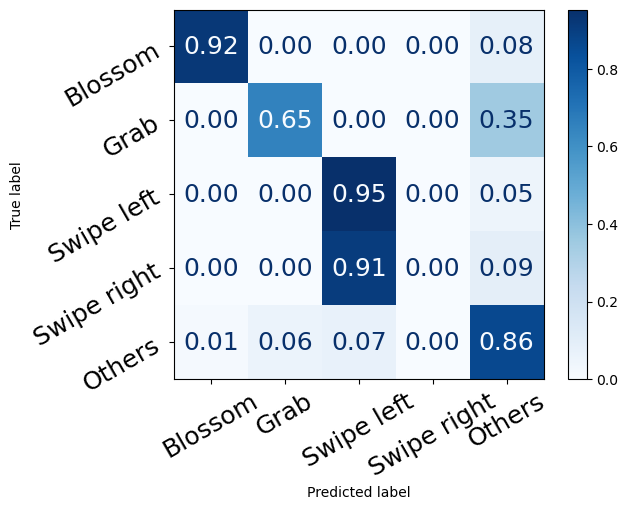

In [49]:
classes = ["Blossom", "Grab", "Swipe left", "Swipe right", "Others"]
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.xticks([0,1,2,3,4], classes, fontsize=18, rotation=30)
plt.yticks([0,1,2,3,4], classes, fontsize=18, rotation=30)
for labels in disp.text_.ravel():
    labels.set_fontsize(18)
plt.show()